# A simple parser for LTspice files

**Scott Prahl**

May 2022

This notebook treats files with op-amps LTspice files back to a simple netlist.

In [1]:
import matplotlib.pyplot as plt
import lcapy
import ltparser

#make matplotlib hires
%config InlineBackend.figure_format='retina'

In [8]:
lt = ltparser.LTspice()
lt.read('../tests/ltspice/inverting-opamp.asc')
print(lt.contents)

Version 4
SHEET 1 880 680
WIRE 464 128 288 128
WIRE 624 128 544 128
WIRE -208 176 -208 144
WIRE 368 208 368 176
WIRE 80 224 -16 224
WIRE 288 224 288 128
WIRE 288 224 160 224
WIRE 336 224 288 224
WIRE 624 240 624 128
WIRE 624 240 400 240
WIRE 688 240 624 240
WIRE 336 256 176 256
WIRE -208 288 -208 256
WIRE -128 288 -208 288
WIRE -16 288 -16 224
WIRE 368 304 368 272
WIRE -208 320 -208 288
WIRE -128 320 -128 288
WIRE 176 352 176 256
WIRE -208 448 -208 400
WIRE -16 464 -16 368
WIRE 176 464 176 432
FLAG -128 320 0
FLAG -208 448 -Vs
FLAG -208 144 +Vs
FLAG 368 176 +Vs
FLAG 368 304 -Vs
FLAG 688 240 Vout
IOPIN 688 240 Out
FLAG 176 464 0
FLAG -16 464 0
SYMBOL Opamps/UniversalOpamp2 368 240 R0
SYMATTR InstName U1
SYMBOL res 176 208 R90
WINDOW 0 0 56 VBottom 2
WINDOW 3 32 56 VTop 2
SYMATTR InstName R1
SYMATTR Value 1k
SYMBOL res 560 112 R90
WINDOW 0 0 56 VBottom 2
WINDOW 3 32 56 VTop 2
SYMATTR InstName R2
SYMATTR Value 5k
SYMBOL res 192 448 R180
WINDOW 0 36 76 Left 2
WINDOW 3 36 40 Left 2
SYMATTR 

In [10]:
lt.parse()
lt.make_netlist()
lt.print_nodes()

-128_0320  :  0
-208_0448  :  -Vs
-208_0144  :  +Vs
0368_0176  :  +Vs
0368_0304  :  -Vs
0688_0240  :  Vout
0176_0464  :  0
-016_0464  :  0
0464_0128  :  9
0288_0128  :  10
0624_0128  :  11
0544_0128  :  12
-208_0176  :  13
0368_0208  :  14
0080_0224  :  15
-016_0224  :  16
0288_0224  :  17
0160_0224  :  18
0336_0224  :  19
0624_0240  :  20
0400_0240  :  21
0336_0256  :  22
0176_0256  :  23
-208_0288  :  24
-208_0256  :  25
-128_0288  :  26
-016_0288  :  27
0368_0272  :  28
-208_0320  :  29
0176_0352  :  30
-208_0400  :  31
-016_0368  :  32
0176_0432  :  33


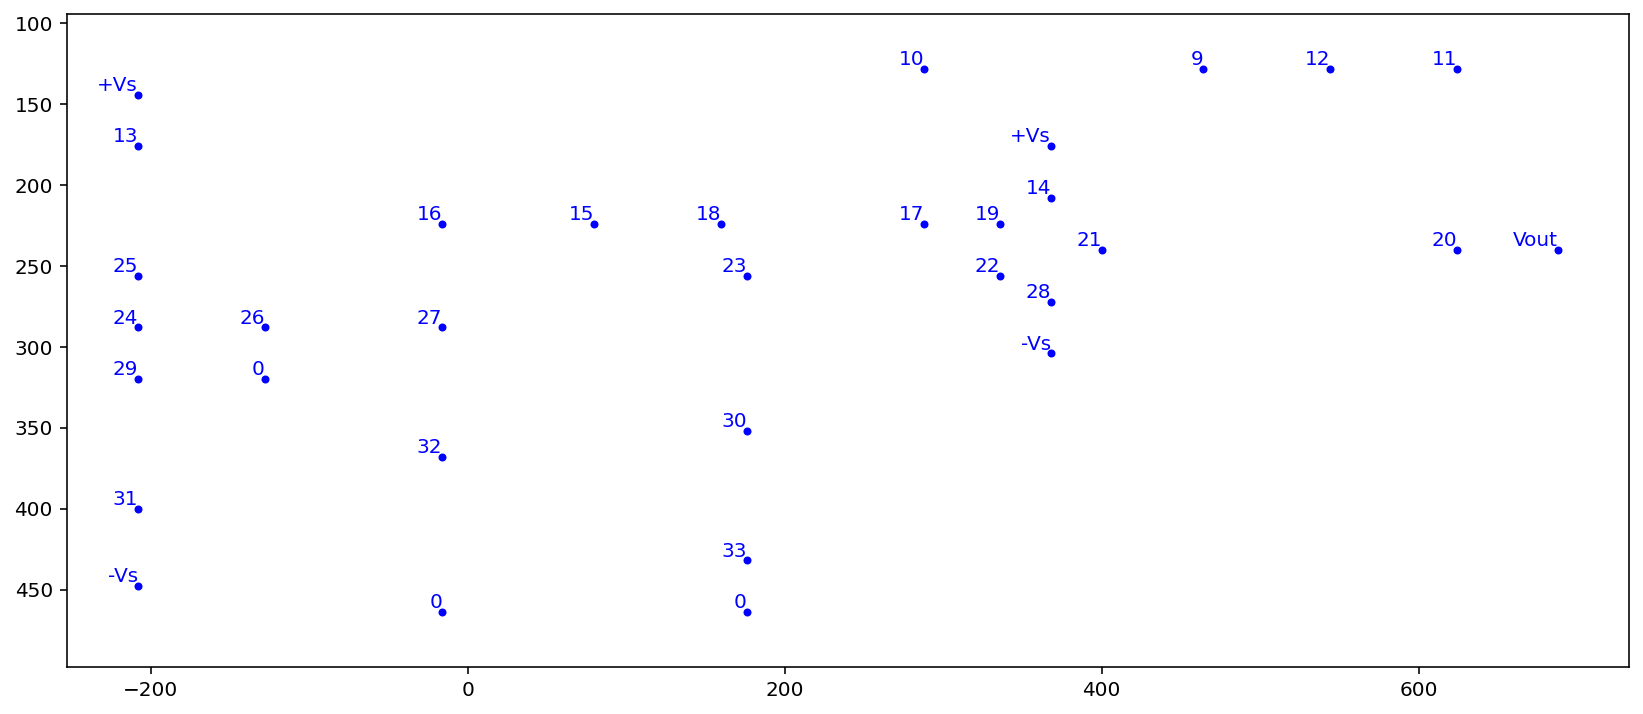

In [11]:
lt.plot_nodes()


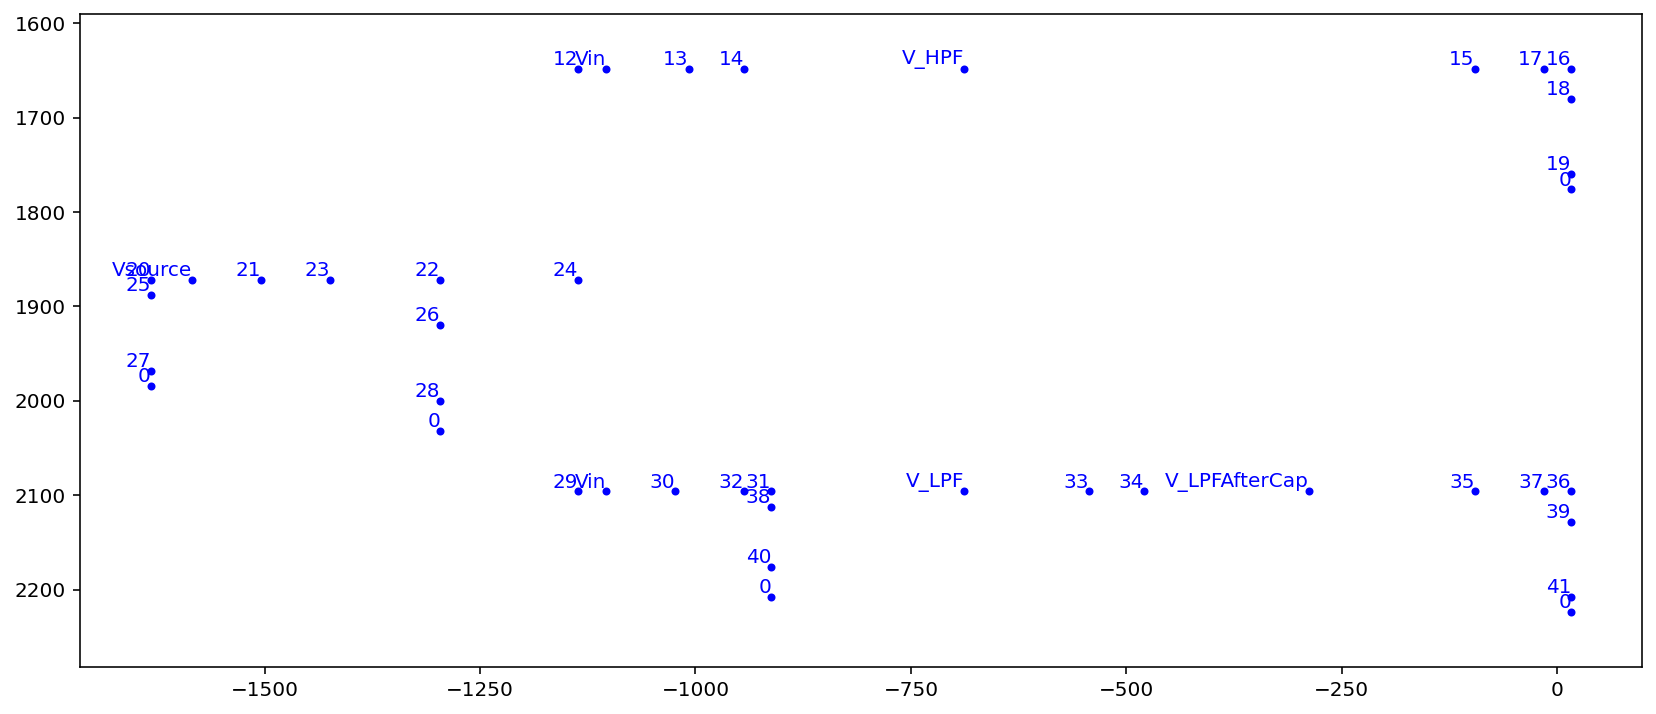

W 12 Vin; right
W Vin 13; right
W 14 V_HPF; right
W V_HPF 15; right
W 17 16; right
W 16 18; down
W 19 0; down
W 20 Vsource; right
W Vsource 21; right
W 23 22; right
W 12 24; down
W 22 24; right
W 20 25; down
W 22 26; down
W 27 0; down
W 28 0; down
W 24 29; down
W 29 Vin; right
W Vin 30; right
W 32 31; right
W 31 V_LPF; right
W V_LPF 33; right
W 34 V_LPFAfterCap; right
W V_LPFAfterCap 35; right
W 37 36; right
W 31 38; down
W 36 39; down
W 40 0; down
W 41 0; down
C_lpf 38 40 5.6000000000000005e-08; down
R_lpf 32 30 1000.0; left
Vsine 25 27 ac 1.000000; down
Rsource 23 21 32.0; left
C_hpf 14 13 4.700000000000001e-09; left
C_dcblock 34 33 1e-06; left
R_Bleeder 26 28 100000.0; down
Rinl 17 15 10000.0; left
V_inputbias1 18 19 2.5; down
Rinr 37 35 10000.0; left
V_inputbias2 39 41 2.5; down



In [5]:
lt = ltparser.LTspice()
lt.read('../tests/ltspice/audio-crossover2.asc')
lt.make_netlist()
lt.plot_nodes()
print(lt.netlist)

In [6]:
cct=lt.circuit()
cct.draw(scale=0.5)

RuntimeError: The vertical schematic graph has a loop.  For example, a node needs to be both above and below another node.  Probably a component is attached to the wrong nodes.


In [ ]:
import imageio
im = imageio.imread('../tests/ltspice/audio-crossover.png')
plt.figure(figsize=(14,6))
plt.imshow(im)
plt.show()

In [ ]:
print(lt.netlist)

In [ ]:
lt.make_graph()

In [ ]:
cct=lt.circuit()
cct.draw(scale=0.5)